In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/시카고 결합x/Chicago_Crimes_2005_to_2007.csv', on_bad_lines='skip')

In [ ]:
df = df.dropna(subset=['X Coordinate','Y Coordinate','Latitude', 'Longitude', 'Location'])

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Case Number,0
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,14
Arrest,0


In [ ]:
# 3. 범죄 데이터의 위도, 경도 정보를 사용해 GeoDataFrame 생성
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
crime_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")  # WGS84 좌표계 설정

In [ ]:
# 4. Community Area CSV 파일 불러오기 (the_geom을 WKT 형식으로 변환)
community_areas = pd.read_csv('/content/drive/MyDrive/CommAreas_20250325.csv')  # Community Area 데이터 (CSV)
community_areas['geometry'] = community_areas['the_geom'].apply(wkt.loads)  # the_geom을 WKT로 변환
community_areas_gdf = gpd.GeoDataFrame(community_areas, geometry='geometry', crs="EPSG:4326")

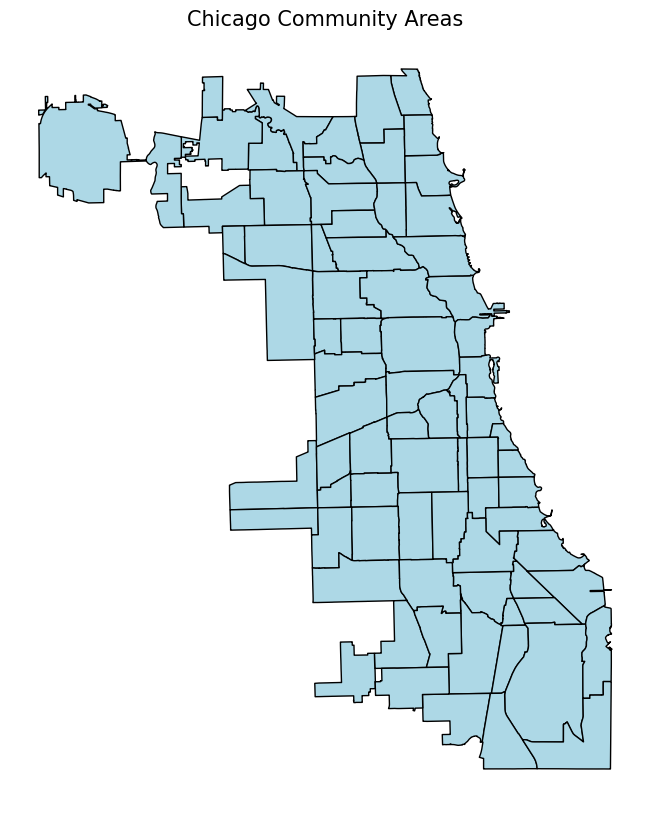

In [ ]:
import matplotlib.pyplot as plt

# Community Area 시각화
fig, ax = plt.subplots(figsize=(10, 10))  # 크기 조정
community_areas_gdf.plot(ax=ax, color='lightblue', edgecolor='black')  # 커뮤니티 영역 시각화

# 제목 추가
ax.set_title("Chicago Community Areas", fontsize=15)

# 축 숨기기
ax.set_axis_off()

# 시각화 출력
plt.show()

In [ ]:
# 5. Ward CSV 파일 불러오기 (the_geom을 WKT 형식으로 변환)
wards = pd.read_csv('/content/drive/MyDrive/Wards_2003_2015.csv')  # Ward 데이터 (CSV)
wards['geometry'] = wards['the_geom'].apply(wkt.loads)  # the_geom을 WKT로 변환
wards_gdf = gpd.GeoDataFrame(wards, geometry='geometry', crs="EPSG:4326")

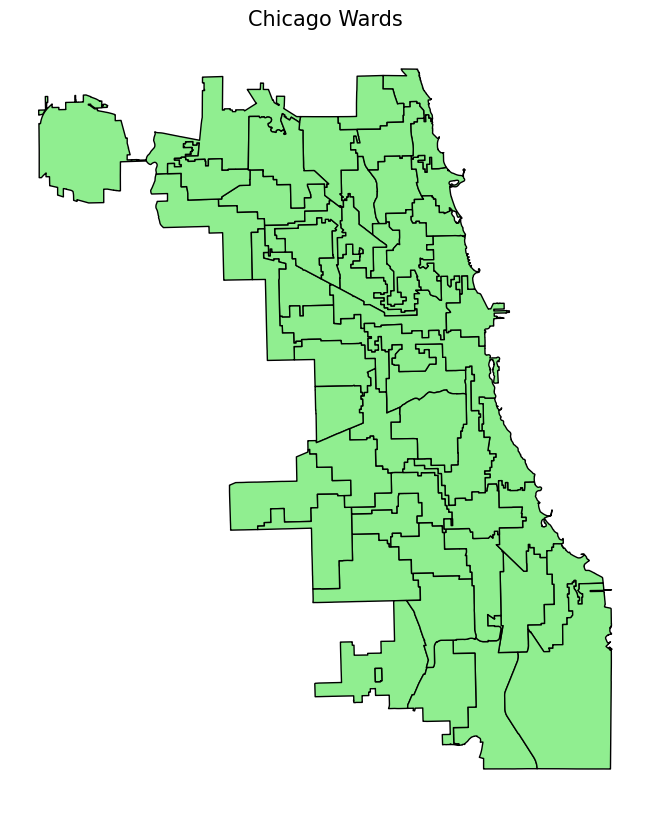

In [ ]:
import matplotlib.pyplot as plt

# Ward 시각화
fig, ax = plt.subplots(figsize=(10, 10))  # 크기 조정
wards_gdf.plot(ax=ax, color='lightgreen', edgecolor='black')  # Ward 영역 시각화

# 제목 추가
ax.set_title("Chicago Wards", fontsize=15)

# 축 숨기기
ax.set_axis_off()

# 시각화 출력
plt.show()

In [ ]:
# 6. 범죄 데이터의 좌표가 어느 Ward에 속하는지 Spatial Join
crime_with_ward = gpd.sjoin(crime_gdf, wards_gdf[['WARD', 'geometry']], how='left', predicate='within')  # Ward 매핑

In [ ]:
# 7. 범죄 데이터의 좌표가 어느 Community Area에 속하는지 Spatial Join
crime_with_community = gpd.sjoin(crime_with_ward, community_areas_gdf[['COMMUNITY', 'geometry']], how='left', predicate='within', lsuffix='_ward', rsuffix='_community')  # Community Area 매핑

In [ ]:
# 8. 'Ward'와 'Community Area' 결측치 채우기
crime_with_community['Ward'] = crime_with_community['Ward'].fillna(crime_with_community['WARD'])
crime_with_community['Community Area'] = crime_with_community['Community Area'].fillna(crime_with_community['COMMUNITY'])

In [ ]:
# 9. 불필요한 열 삭제 (매핑된 'WARD', 'COMMUNITY' 열 제거)
crime_with_community = crime_with_community.drop(columns=['WARD', 'COMMUNITY','index_right','index__community'])

In [ ]:
crime_with_community = crime_with_community.drop(columns=['geometry'])

In [ ]:
# 10. 결측치 확인
print(crime_with_community[['Ward', 'Community Area']].isna().sum())  # 결측치 확인

Ward              2
Community Area    5
dtype: int64


In [ ]:
crime_with_community.isna().sum()

,0
Unnamed: 0,0
ID,0
Case Number,0
Date,0
Block,0
IUCR,0
Primary Type,0
Description,0
Location Description,14
Arrest,0


In [ ]:
# 11. 결과를 CSV로 저장
crime_with_community.to_csv('/content/drive/MyDrive/chicago_crime_data_with_ward_community2.csv', index=False)

In [ ]:
crime_with_community[['ID', 'Ward', 'Community Area']]

,ID,Ward,Community Area
0,4673626,45.0,11.0
1,4673627,20.0,42.0
2,4673628,5.0,69.0
3,4673629,38.0,17.0
4,4673630,13.0,65.0
...,...,...,...
1872338,4673620,28.0,26.0
1872339,4673621,38.0,15.0
1872340,4673622,8.0,44.0
1872341,4673623,5.0,41.0
